In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [4]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py -O tf_keras_model.py

--2022-06-16 14:48:43--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7801 (7.6K) [text/plain]
Saving to: ‘tf_keras_model.py’

tf_keras_model.py   100%[===================>]   7.62K  --.-KB/s    in 0.004s  

2022-06-16 14:48:43 (1.69 MB/s) - ‘tf_keras_model.py’ saved [7801/7801]



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# VANNO TUTTI CAMBIATI

# !wget https://www.dropbox.com/s/6s5khncrval4rz9/bkg_et.npy?dl=1 -o bkg_et.npy
# !wget https://www.dropbox.com/s/qc7z1nhqh5xvpbg/bkg_mask.npy?dl=1 -o bkg_mask.npy
# !wget https://www.dropbox.com/s/fs5e9wuhqtr66xh/bkg_xy.npy?dl=1 -o bkg_xy.npy
# !wget https://www.dropbox.com/s/w0b94xzyk2wg7y4/signal_et.npy?dl=1 -o signal_et.npy
# !wget https://www.dropbox.com/s/3k6b0u3zz65xnyf/signal_mask.npy?dl=1 -o signal_mask.npy
# !wget https://www.dropbox.com/s/chcep3q8terrj4k/signal_xy.npy?dl=1 -o signal_xy.npy

In [5]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite, edge_conv

[2022-06-16 14:53:56,589] INFO: NumExpr defaulting to 2 threads.


In [15]:
data_folder = "/content/drive/MyDrive/datiML"

name_map = {"points": "xy", "features": "et", "mask": "mask", "summary": "etrn"} # va provato sia xy che rphi

signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

In [16]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [17]:
'''
cluster su disco 0 in un injection cycle:
RMC: 330
MNBS: 107k
cosmici: 4

cluster simulati su disco 0:
RMC: 150k
MNBS: 16505 * 5 = 82k
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 107k/82k
Cosmici: 4/53k
'''

signal_weight = 330/150e3 * 100
mnbs_weight = 0.24 * 100
cosmics_weight = 4/53e3 * 100

In [22]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"#Entries per signale, mnbs e cosmici:{entries_list}")
print(f"#Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

#Entries per signale, mnbs e cosmici:[41372, 1132, 41598]
#Pesi per signale, mnbs e cosmici:[0.22, 24.0, 0.007547169811320755]


In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for key in ["points", "features"]:
  scaler.fit(data[key][data["mask"].reshape(N, 50)])
  data[key][data["mask"].reshape(N, 50)] = scaler.transform(data[key][data["mask"].reshape(N, 50)])

scaler.fit(data["summary"])
data["summary"] = scaler.transform(data["summary"])

In [24]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

In [37]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = 2
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [38]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [39]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

[2022-06-16 15:03:21,517] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_2 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_4 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_2[0][0]']    
                                                                                                  
 tf.math.equal_2 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_4[0][0]']    

In [41]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar, lr_scheduler]

In [42]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"], train_data["summary"]], 
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"], val_data["summary"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks
)

Epoch 1/30


[2022-06-16 15:03:38,897] INFO: Learning rate: 0.001000


      0/Unknown - 11s 0s/sample - loss: 0.1828 - accuracy: 0.5566 - precision_2: 0.5824 - recall_2: 0.3499
Epoch 1: val_accuracy improved from -inf to 0.55748, saving model to model_checkpoints/particle_net_lite_model.001.h5
58/58 [==============================] - 14s 241ms/sample - loss: 0.1828 - accuracy: 0.5566 - precision_2: 0.5824 - recall_2: 0.3499 - val_loss: 0.2144 - val_accuracy: 0.5575 - val_precision_2: 0.5525 - val_recall_2: 0.4966
Epoch 2/30


[2022-06-16 15:03:52,851] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.1215 - accuracy: 0.5819 - precision_2: 0.5604 - recall_2: 0.6968
Epoch 2: val_accuracy improved from 0.55748 to 0.60587, saving model to model_checkpoints/particle_net_lite_model.002.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.1215 - accuracy: 0.5819 - precision_2: 0.5604 - recall_2: 0.6968 - val_loss: 0.1994 - val_accuracy: 0.6059 - val_precision_2: 0.5935 - val_recall_2: 0.6139
Epoch 3/30


[2022-06-16 15:04:02,473] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0989 - accuracy: 0.6224 - precision_2: 0.5945 - recall_2: 0.7320
Epoch 3: val_accuracy improved from 0.60587 to 0.65890, saving model to model_checkpoints/particle_net_lite_model.003.h5
58/58 [==============================] - 10s 168ms/sample - loss: 0.0989 - accuracy: 0.6224 - precision_2: 0.5945 - recall_2: 0.7320 - val_loss: 0.1958 - val_accuracy: 0.6589 - val_precision_2: 0.6193 - val_recall_2: 0.7837
Epoch 4/30


[2022-06-16 15:04:12,231] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0868 - accuracy: 0.6681 - precision_2: 0.6278 - recall_2: 0.7997
Epoch 4: val_accuracy improved from 0.65890 to 0.68601, saving model to model_checkpoints/particle_net_lite_model.004.h5
58/58 [==============================] - 10s 170ms/sample - loss: 0.0868 - accuracy: 0.6681 - precision_2: 0.6278 - recall_2: 0.7997 - val_loss: 0.1553 - val_accuracy: 0.6860 - val_precision_2: 0.6455 - val_recall_2: 0.7929
Epoch 5/30


[2022-06-16 15:04:22,075] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0789 - accuracy: 0.6979 - precision_2: 0.6547 - recall_2: 0.8172
Epoch 5: val_accuracy improved from 0.68601 to 0.71276, saving model to model_checkpoints/particle_net_lite_model.005.h5
58/58 [==============================] - 10s 168ms/sample - loss: 0.0789 - accuracy: 0.6979 - precision_2: 0.6547 - recall_2: 0.8172 - val_loss: 0.1429 - val_accuracy: 0.7128 - val_precision_2: 0.6459 - val_recall_2: 0.9124
Epoch 6/30


[2022-06-16 15:04:31,807] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0758 - accuracy: 0.7138 - precision_2: 0.6673 - recall_2: 0.8347
Epoch 6: val_accuracy improved from 0.71276 to 0.72762, saving model to model_checkpoints/particle_net_lite_model.006.h5
58/58 [==============================] - 10s 167ms/sample - loss: 0.0758 - accuracy: 0.7138 - precision_2: 0.6673 - recall_2: 0.8347 - val_loss: 0.0884 - val_accuracy: 0.7276 - val_precision_2: 0.6631 - val_recall_2: 0.8998
Epoch 7/30


[2022-06-16 15:04:41,489] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0714 - accuracy: 0.7274 - precision_2: 0.6795 - recall_2: 0.8441
Epoch 7: val_accuracy improved from 0.72762 to 0.74034, saving model to model_checkpoints/particle_net_lite_model.007.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0714 - accuracy: 0.7274 - precision_2: 0.6795 - recall_2: 0.8441 - val_loss: 0.0832 - val_accuracy: 0.7403 - val_precision_2: 0.6753 - val_recall_2: 0.9024
Epoch 8/30


[2022-06-16 15:04:51,071] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0677 - accuracy: 0.7479 - precision_2: 0.6990 - recall_2: 0.8563
Epoch 8: val_accuracy improved from 0.74034 to 0.77090, saving model to model_checkpoints/particle_net_lite_model.008.h5
58/58 [==============================] - 10s 164ms/sample - loss: 0.0677 - accuracy: 0.7479 - precision_2: 0.6990 - recall_2: 0.8563 - val_loss: 0.0716 - val_accuracy: 0.7709 - val_precision_2: 0.7141 - val_recall_2: 0.8856
Epoch 9/30


[2022-06-16 15:05:00,590] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0642 - accuracy: 0.7616 - precision_2: 0.7148 - recall_2: 0.8580
Epoch 9: val_accuracy improved from 0.77090 to 0.77886, saving model to model_checkpoints/particle_net_lite_model.009.h5
58/58 [==============================] - 10s 164ms/sample - loss: 0.0642 - accuracy: 0.7616 - precision_2: 0.7148 - recall_2: 0.8580 - val_loss: 0.0618 - val_accuracy: 0.7789 - val_precision_2: 0.7178 - val_recall_2: 0.9022
Epoch 10/30


[2022-06-16 15:05:10,121] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0592 - accuracy: 0.7708 - precision_2: 0.7178 - recall_2: 0.8803
Epoch 10: val_accuracy improved from 0.77886 to 0.78171, saving model to model_checkpoints/particle_net_lite_model.010.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0592 - accuracy: 0.7708 - precision_2: 0.7178 - recall_2: 0.8803 - val_loss: 0.0584 - val_accuracy: 0.7817 - val_precision_2: 0.7316 - val_recall_2: 0.8740
Epoch 11/30


[2022-06-16 15:05:19,699] INFO: Learning rate: 0.001000


 0/58 [..............................] - ETA: 0s - loss: 0.0633 - accuracy: 0.7778 - precision_2: 0.7316 - recall_2: 0.8663
Epoch 11: val_accuracy improved from 0.78171 to 0.80050, saving model to model_checkpoints/particle_net_lite_model.011.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0633 - accuracy: 0.7778 - precision_2: 0.7316 - recall_2: 0.8663 - val_loss: 0.0705 - val_accuracy: 0.8005 - val_precision_2: 0.7458 - val_recall_2: 0.8978
Epoch 12/30


[2022-06-16 15:05:29,296] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0539 - accuracy: 0.7929 - precision_2: 0.7444 - recall_2: 0.8822
Epoch 12: val_accuracy improved from 0.80050 to 0.80371, saving model to model_checkpoints/particle_net_lite_model.012.h5
58/58 [==============================] - 10s 169ms/sample - loss: 0.0539 - accuracy: 0.7929 - precision_2: 0.7444 - recall_2: 0.8822 - val_loss: 0.0579 - val_accuracy: 0.8037 - val_precision_2: 0.7460 - val_recall_2: 0.9071
Epoch 13/30


[2022-06-16 15:05:39,098] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0528 - accuracy: 0.7957 - precision_2: 0.7432 - recall_2: 0.8935
Epoch 13: val_accuracy did not improve from 0.80371
58/58 [==============================] - 10s 164ms/sample - loss: 0.0528 - accuracy: 0.7957 - precision_2: 0.7432 - recall_2: 0.8935 - val_loss: 0.0556 - val_accuracy: 0.8015 - val_precision_2: 0.7477 - val_recall_2: 0.8961
Epoch 14/30


[2022-06-16 15:05:48,618] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0518 - accuracy: 0.7956 - precision_2: 0.7425 - recall_2: 0.8950
Epoch 14: val_accuracy did not improve from 0.80371
58/58 [==============================] - 9s 164ms/sample - loss: 0.0518 - accuracy: 0.7956 - precision_2: 0.7425 - recall_2: 0.8950 - val_loss: 0.0535 - val_accuracy: 0.7999 - val_precision_2: 0.7516 - val_recall_2: 0.8820
Epoch 15/30


[2022-06-16 15:05:58,114] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0507 - accuracy: 0.7955 - precision_2: 0.7446 - recall_2: 0.8894
Epoch 15: val_accuracy improved from 0.80371 to 0.80858, saving model to model_checkpoints/particle_net_lite_model.015.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0507 - accuracy: 0.7955 - precision_2: 0.7446 - recall_2: 0.8894 - val_loss: 0.0536 - val_accuracy: 0.8086 - val_precision_2: 0.7519 - val_recall_2: 0.9078
Epoch 16/30


[2022-06-16 15:06:07,729] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0499 - accuracy: 0.8000 - precision_2: 0.7458 - recall_2: 0.9004
Epoch 16: val_accuracy did not improve from 0.80858
58/58 [==============================] - 9s 163ms/sample - loss: 0.0499 - accuracy: 0.8000 - precision_2: 0.7458 - recall_2: 0.9004 - val_loss: 0.0526 - val_accuracy: 0.8022 - val_precision_2: 0.7536 - val_recall_2: 0.8842
Epoch 17/30


[2022-06-16 15:06:17,201] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0491 - accuracy: 0.7976 - precision_2: 0.7455 - recall_2: 0.8939
Epoch 17: val_accuracy did not improve from 0.80858
58/58 [==============================] - 9s 163ms/sample - loss: 0.0491 - accuracy: 0.7976 - precision_2: 0.7455 - recall_2: 0.8939 - val_loss: 0.0528 - val_accuracy: 0.8044 - val_precision_2: 0.7539 - val_recall_2: 0.8905
Epoch 18/30


[2022-06-16 15:06:26,639] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0493 - accuracy: 0.8005 - precision_2: 0.7473 - recall_2: 0.8984
Epoch 18: val_accuracy did not improve from 0.80858
58/58 [==============================] - 9s 162ms/sample - loss: 0.0493 - accuracy: 0.8005 - precision_2: 0.7473 - recall_2: 0.8984 - val_loss: 0.0518 - val_accuracy: 0.8074 - val_precision_2: 0.7547 - val_recall_2: 0.8976
Epoch 19/30


[2022-06-16 15:06:36,074] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0487 - accuracy: 0.8042 - precision_2: 0.7515 - recall_2: 0.8996
Epoch 19: val_accuracy improved from 0.80858 to 0.81013, saving model to model_checkpoints/particle_net_lite_model.019.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0487 - accuracy: 0.8042 - precision_2: 0.7515 - recall_2: 0.8996 - val_loss: 0.0510 - val_accuracy: 0.8101 - val_precision_2: 0.7570 - val_recall_2: 0.9005
Epoch 20/30


[2022-06-16 15:06:45,635] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0489 - accuracy: 0.8038 - precision_2: 0.7520 - recall_2: 0.8970
Epoch 20: val_accuracy improved from 0.81013 to 0.81286, saving model to model_checkpoints/particle_net_lite_model.020.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0489 - accuracy: 0.8038 - precision_2: 0.7520 - recall_2: 0.8970 - val_loss: 0.0521 - val_accuracy: 0.8129 - val_precision_2: 0.7584 - val_recall_2: 0.9056
Epoch 21/30


[2022-06-16 15:06:55,210] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0512 - accuracy: 0.8020 - precision_2: 0.7526 - recall_2: 0.8904
Epoch 21: val_accuracy did not improve from 0.81286
58/58 [==============================] - 9s 163ms/sample - loss: 0.0512 - accuracy: 0.8020 - precision_2: 0.7526 - recall_2: 0.8904 - val_loss: 0.0558 - val_accuracy: 0.8114 - val_precision_2: 0.7661 - val_recall_2: 0.8839
Epoch 22/30


[2022-06-16 15:07:04,668] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0475 - accuracy: 0.8075 - precision_2: 0.7536 - recall_2: 0.9045
Epoch 22: val_accuracy improved from 0.81286 to 0.81524, saving model to model_checkpoints/particle_net_lite_model.022.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0475 - accuracy: 0.8075 - precision_2: 0.7536 - recall_2: 0.9045 - val_loss: 0.0528 - val_accuracy: 0.8152 - val_precision_2: 0.7619 - val_recall_2: 0.9046
Epoch 23/30


[2022-06-16 15:07:14,251] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0481 - accuracy: 0.8075 - precision_2: 0.7548 - recall_2: 0.9017
Epoch 23: val_accuracy did not improve from 0.81524
58/58 [==============================] - 9s 163ms/sample - loss: 0.0481 - accuracy: 0.8075 - precision_2: 0.7548 - recall_2: 0.9017 - val_loss: 0.0518 - val_accuracy: 0.8152 - val_precision_2: 0.7632 - val_recall_2: 0.9017
Epoch 24/30


[2022-06-16 15:07:23,699] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0461 - accuracy: 0.8102 - precision_2: 0.7578 - recall_2: 0.9030
Epoch 24: val_accuracy improved from 0.81524 to 0.81857, saving model to model_checkpoints/particle_net_lite_model.024.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0461 - accuracy: 0.8102 - precision_2: 0.7578 - recall_2: 0.9030 - val_loss: 0.0513 - val_accuracy: 0.8186 - val_precision_2: 0.7646 - val_recall_2: 0.9083
Epoch 25/30


[2022-06-16 15:07:33,265] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0480 - accuracy: 0.8097 - precision_2: 0.7580 - recall_2: 0.9009
Epoch 25: val_accuracy did not improve from 0.81857
58/58 [==============================] - 9s 164ms/sample - loss: 0.0480 - accuracy: 0.8097 - precision_2: 0.7580 - recall_2: 0.9009 - val_loss: 0.0512 - val_accuracy: 0.8168 - val_precision_2: 0.7662 - val_recall_2: 0.8995
Epoch 26/30


[2022-06-16 15:07:42,761] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0481 - accuracy: 0.8105 - precision_2: 0.7598 - recall_2: 0.8993
Epoch 26: val_accuracy did not improve from 0.81857
58/58 [==============================] - 9s 164ms/sample - loss: 0.0481 - accuracy: 0.8105 - precision_2: 0.7598 - recall_2: 0.8993 - val_loss: 0.0534 - val_accuracy: 0.8168 - val_precision_2: 0.7728 - val_recall_2: 0.8854
Epoch 27/30


[2022-06-16 15:07:52,258] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0465 - accuracy: 0.8140 - precision_2: 0.7608 - recall_2: 0.9072
Epoch 27: val_accuracy improved from 0.81857 to 0.82178, saving model to model_checkpoints/particle_net_lite_model.027.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0465 - accuracy: 0.8140 - precision_2: 0.7608 - recall_2: 0.9072 - val_loss: 0.0513 - val_accuracy: 0.8218 - val_precision_2: 0.7717 - val_recall_2: 0.9022
Epoch 28/30


[2022-06-16 15:08:01,861] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0477 - accuracy: 0.8137 - precision_2: 0.7648 - recall_2: 0.8972
Epoch 28: val_accuracy improved from 0.82178 to 0.82594, saving model to model_checkpoints/particle_net_lite_model.028.h5
58/58 [==============================] - 10s 165ms/sample - loss: 0.0477 - accuracy: 0.8137 - precision_2: 0.7648 - recall_2: 0.8972 - val_loss: 0.0524 - val_accuracy: 0.8259 - val_precision_2: 0.7743 - val_recall_2: 0.9088
Epoch 29/30


[2022-06-16 15:08:11,448] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0461 - accuracy: 0.8171 - precision_2: 0.7657 - recall_2: 0.9054
Epoch 29: val_accuracy improved from 0.82594 to 0.82725, saving model to model_checkpoints/particle_net_lite_model.029.h5
58/58 [==============================] - 10s 166ms/sample - loss: 0.0461 - accuracy: 0.8171 - precision_2: 0.7657 - recall_2: 0.9054 - val_loss: 0.0511 - val_accuracy: 0.8273 - val_precision_2: 0.7752 - val_recall_2: 0.9105
Epoch 30/30


[2022-06-16 15:08:21,058] INFO: Learning rate: 0.000100


 0/58 [..............................] - ETA: 0s - loss: 0.0456 - accuracy: 0.8198 - precision_2: 0.7674 - recall_2: 0.9094
Epoch 30: val_accuracy did not improve from 0.82725
58/58 [==============================] - 9s 163ms/sample - loss: 0.0456 - accuracy: 0.8198 - precision_2: 0.7674 - recall_2: 0.9094 - val_loss: 0.0508 - val_accuracy: 0.8231 - val_precision_2: 0.7743 - val_recall_2: 0.9005


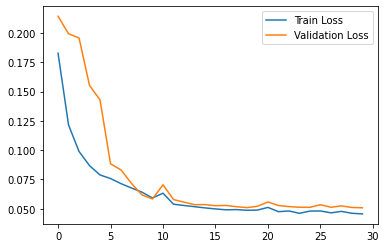

In [43]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

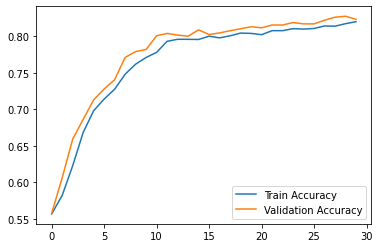

In [44]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

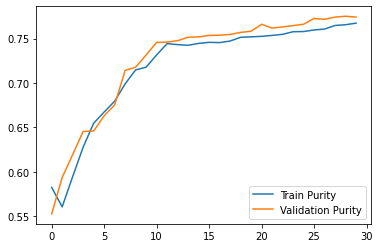

In [50]:
plt.plot(history.history['precision_2'], label="Train Purity")
plt.plot(history.history['val_precision_2'], label="Validation Purity")
plt.legend()

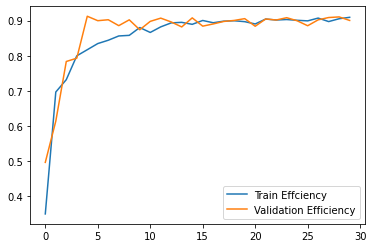

In [49]:
plt.plot(history.history['recall_2'], label="Train Effciency")
plt.plot(history.history['val_recall_2'], label="Validation Efficiency")
plt.legend()

In [51]:
model.load_weights("model_checkpoints/particle_net_lite_model.029.h5")

In [52]:
probs = model.predict_on_batch(test_data)

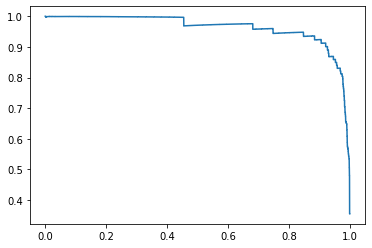

In [53]:
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)